In [11]:
!rm -rf /content/light-transport

In [1]:
!git clone https://github.com/dipanjan92/light-transport.git

Cloning into 'light-transport'...
remote: Enumerating objects: 198, done.
remote: Counting objects: 100% (198/198), done.
remote: Compressing objects: 100% (138/138), done.
remote: Total 198 (delta 89), reused 168 (delta 60), pack-reused 0
Receiving objects: 100% (198/198), 6.60 MiB | 10.42 MiB/s, done.
Resolving deltas: 100% (89/89), done.


In [2]:
import sys
sys.path.insert(0,'/content/light-transport/LightTransportSimulator')

In [3]:
!pip install pyvista

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
import math
import os
import shutil
import time
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import numba
import pyvista as pv

In [18]:
os.chdir('/content/light-transport/')
os.getcwd()

FileNotFoundError: [WinError 3] The system cannot find the path specified: '/content/light-transport/'

In [ ]:
from LightTransportSimulator.light_transport.src.scene import Scene, Light
from LightTransportSimulator.light_transport.src.primitives import Triangle, PreComputedTriangle
from LightTransportSimulator.light_transport.src.cornell_box import get_cornell_box, get_floor
from LightTransportSimulator.light_transport.src.colors import *

In [19]:
#load object
mesh = pv.Cone(radius=2, center=[0,0,0], height=5)
tri = mesh.triangulate()
points = np.ascontiguousarray(tri.points)
faces = tri.faces.reshape((-1,4))[:, 1:4]
vertices = np.ascontiguousarray(points[faces], dtype=np.float64)
len(vertices)

10

In [20]:
#set scene depths

xmax, ymax, zmax = points.max(axis=0)
xmin, ymin, zmin = points.min(axis=0)

padding = 5
depth = abs(max(xmax, ymax, zmax)) + padding
x_depth = abs(xmax) + 10
y_depth = abs(ymax) + 1
z_depth = abs(zmax) + 10
xmax, ymax, zmax, depth

(2.5, 2.0, 1.7320508, 7.5)

In [21]:
# empty object list
objects = numba.typed.List()

In [22]:
start_id = len(objects)
surface_color = WHITE_2
left_wall_color = GREEN
right_wall_color = RED
surface_mat = Material(color=surface_color, shininess=30, reflection=0.1, ior=1.5210, transmission=1) # calcium sulphate
left_wall_mat = Material(color=left_wall_color, shininess=30, reflection=0.1, ior=1.5210, transmission=1)
right_wall_mat = Material(color=right_wall_color, shininess=30, reflection=0.1, ior=1.5210, transmission=1)

objects = get_cornell_box(depth, surface_mat, left_wall_mat, right_wall_mat, start_id)

In [23]:
id = len(objects)+1
for v in vertices:
    a,b,c = np.append(v[0], 1),np.append(v[1], 1),np.append(v[2], 1)
    id+=1
    triangle = PreComputedTriangle(id=id,
                                   vertex_1=np.ascontiguousarray(a, dtype=np.float64),
                                   vertex_2=np.ascontiguousarray(b, dtype=np.float64),
                                   vertex_3=np.ascontiguousarray(c, dtype=np.float64),
                                   material=GLASS_MAT)
    objects.append(triangle)

objects

ListType[instance.jitclass.PreComputedTriangle#1fd0b2d2bc0<type:int64,id:int64,vertex_1:array(float64, 1d, C),vertex_2:array(float64, 1d, C),vertex_3:array(float64, 1d, C),centroid:array(float64, 1d, C),material:instance.jitclass.Material#1fd0b2d10c0<color:instance.jitclass.Color#1fd0b324a30<ambient:array(float64, 1d, A),diffuse:array(float64, 1d, A),specular:array(float64, 1d, A)>,shininess:float64,reflection:float64,ior:float64,is_diffuse:bool,is_mirror:bool,emission:float64,transmission:float64>,is_light:bool,edge_1:array(float64, 1d, C),edge_2:array(float64, 1d, C),normal:array(float64, 1d, C),num:float64,transformation:array(float64, 2d, A)>]([<numba.experimental.jitclass.boxing.PreComputedTriangle object at 0x000001FD10998310>, <numba.experimental.jitclass.boxing.PreComputedTriangle object at 0x000001FD1099B5B0>, <numba.experimental.jitclass.boxing.PreComputedTriangle object at 0x000001FD10998310>, <numba.experimental.jitclass.boxing.PreComputedTriangle object at 0x000001FD1099B5

In [24]:
# global light source
light_sources = numba.typed.List()

source_mat = Material(color=WHITE, shininess=1, reflection=0.9, ior=1.5, emission=10000)

id = len(objects)+1

light_1 = PreComputedTriangle(id=id,
                              vertex_1=np.array([-1, depth, -1, 1], dtype=np.float64),
                              vertex_2=np.array([1, depth, 1, 1], dtype=np.float64),
                              vertex_3=np.array([-1, depth, 1, 1], dtype=np.float64),
                              material=source_mat,
                              is_light=True)
id += 1

light_2 = PreComputedTriangle(id=id,
                              vertex_1=np.array([-1, depth, -1, 1], dtype=np.float64),
                              vertex_2=np.array([1, depth, -1, 1], dtype=np.float64),
                              vertex_3=np.array([1, depth, 1, 1], dtype=np.float64),
                              material=source_mat,
                              is_light=True)


light_samples = 10
a = np.random.uniform(0,1,light_samples)
b = np.random.uniform(1,0,light_samples)

for x in range(light_samples):
    tp1 = light_1.vertex_1 * (1-math.sqrt(a[x])) + light_1.vertex_2 * (math.sqrt(a[x])*(1-b[x])) + light_1.vertex_3 * (b[x]*math.sqrt(a[x]))
    l1 = Light(source=tp1, material=source_mat)
    light_sources.append(l1)
    tp2 = light_2.vertex_1 * (1-math.sqrt(a[x])) + light_2.vertex_2 * (math.sqrt(a[x])*(1-b[x])) + light_2.vertex_3 * (b[x]*math.sqrt(a[x]))
    l2 = Light(source=tp1, material=source_mat)
    light_sources.append(l2)

light_sources

ListType[instance.jitclass.Light#1fd0b2d1c00<source:array(float64, 1d, A),material:instance.jitclass.Material#1fd0b2d10c0<color:instance.jitclass.Color#1fd0b324a30<ambient:array(float64, 1d, A),diffuse:array(float64, 1d, A),specular:array(float64, 1d, A)>,shininess:float64,reflection:float64,ior:float64,is_diffuse:bool,is_mirror:bool,emission:float64,transmission:float64>>]([<numba.experimental.jitclass.boxing.Light object at 0x000001FD106437C0>, <numba.experimental.jitclass.boxing.Light object at 0x000001FD10643D30>, <numba.experimental.jitclass.boxing.Light object at 0x000001FD106437C0>, <numba.experimental.jitclass.boxing.Light object at 0x000001FD10643D30>, <numba.experimental.jitclass.boxing.Light object at 0x000001FD106437C0>, <numba.experimental.jitclass.boxing.Light object at 0x000001FD10643D30>, <numba.experimental.jitclass.boxing.Light object at 0x000001FD106437C0>, <numba.experimental.jitclass.boxing.Light object at 0x000001FD10643D30>, <numba.experimental.jitclass.boxing.Li

In [25]:
objects.append(light_1)
objects.append(light_2)

In [26]:
# setup scene

#camera
camera = np.array([0, 0, depth+0.5, 1], dtype=np.float64)

#screen
width=400
height=400
max_depth=3

#scene
scene = Scene(camera=camera, lights=light_sources, width=width, height=height, max_depth=max_depth, depth=depth)

In [27]:
from LightTransportSimulator.light_transport.src.primitives import AABB
# min_point=np.array([scene.left, scene.bottom, -scene.depth], dtype=np.float64)
# max_point=np.array([scene.right, scene.top, scene.depth], dtype=np.float64)
min_point=np.array([-depth, -depth, depth], dtype=np.float64)
max_point=np.array([depth, depth, -depth], dtype=np.float64)
box = AABB(min_point=min_point, max_point=max_point)
box

In [28]:
from LightTransportSimulator.light_transport.src.bvh import BVH

bvh = BVH()
bvh.insert(objects, box)

In [29]:
from LightTransportSimulator.light_transport.src.render import render_scene

start = time.time()
image = render_scene(scene, bvh.top)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

2.0
2.0
2.0
2.0
2.0
2.0
2.0
4.0
2.0
4.0
4.0
4.0
4.0
4.0
4.0
6.0
6.0
6.0
6.0
6.0
4.0
6.0
8.0
8.0
6.0
8.0
8.0
8.0
10.0
10.0
8.0
10.0
8.0
10.0
10.0
6.0
12.0
12.0
12.0
10.0
12.0
10.0
12.0
14.0
14.0
14.0
8.0
12.0
14.0
14.0
16.0
12.0
16.0
16.0
16.0
14.0
16.0
18.0
10.0
18.0
18.0
14.0
18.0
20.0
20.0
20.0
16.0
18.0
16.0
22.0
20.0
12.0
22.0
22.0
20.0
18.0
18.0
24.0
22.0
24.0
24.0
22.0
26.0
20.0
14.0
20.0
26.0
26.0
24.0
24.0
28.0
22.0
28.0
28.0
22.0
26.0
16.0
30.0
26.0
30.0
30.0
24.0
28.0
24.0
32.0
28.0
32.0
32.0
18.0
26.0
30.0
34.0
26.0
34.0
34.0
30.0
36.0
32.0
28.0
20.0
28.0
36.0
36.0
32.0
38.0
34.0
30.0
38.0
38.0
30.0
40.0
22.0
36.0
34.0
40.0
40.0
32.0
42.0
32.0
38.0
42.0
36.0
42.0
44.0
24.0
34.0
34.0
44.0
40.0
44.0
46.0
38.0
36.0
46.0
42.0
36.0
26.0
46.0
48.0
40.0
48.0
38.0
44.0
48.0
50.0
38.0
28.0
42.0
50.0
46.0
40.0
52.0
50.0
40.0
52.0
54.0
52.0
48.0
44.0
42.0
30.0
42.0
54.0
56.0
54.0
50.0
46.0
44.0
56.0
58.0
44.0
32.0
56.0
52.0
58.0
60.0
46.0
48.0
58.0
46.0
54.0
34.0
62.0
60.0
48.0
50.0
60

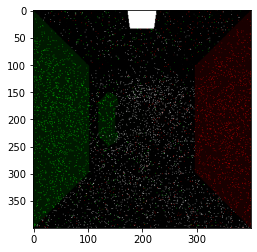

In [30]:
plt.imshow(image)